<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [ ]:
# The code was removed by Watson Studio for sharing.

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-10-19 04:04:47--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.001s  

2019-10-19 04:04:47 (22.8 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()
col = [0,1]
df.drop(df.columns[col], axis = 1, inplace = True) 
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 8)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [24]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.9.11          |           py36_0         154 KB  anaconda
    ca-certificates-2019.8.28  |                0         132 KB  anaconda
    openssl-1.1.1              |       h7b6447c_0         5.0 MB  anaconda
    seaborn-0.9.0              |           py36_0         379 KB  anaconda
    ------------------------------------------------------------
                                           Total:         5.7 MB

The following packages will be UPDATED:

    ca-certificates: 2019.8.28-0       --> 2019.8.28-0      anaconda
    certifi:         2019.9.11-py36_0  --> 2019.9.11-py36_0 anaconda
    openssl:         1.1.1d-h7b6447c_2 --> 1.1.1-h7b6447c_0 anaconda
    seaborn:         0.9.0-py36_0     

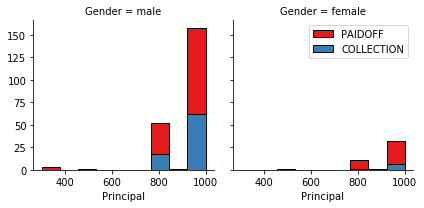

In [7]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

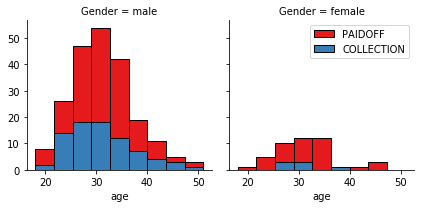

In [8]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

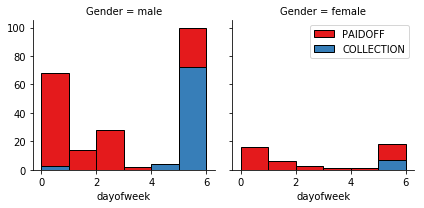

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 7)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [10]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [11]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [12]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [14]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [15]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [16]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [17]:
y = df['loan_status'].values
#replace the value with numeric value
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)
y = df['loan_status'].values
y[0:5]

array([1, 1, 1, 1, 1])

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [18]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

In [19]:
# Split the Data before processing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.25, random_state = 9)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (259, 8) (259,)
Test set: (87, 8) (87,)


# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [21]:
K =11
mean_acc = np.zeros(K-1)
std_acc = np.zeros(K-1)
roc = np.zeros(K-1)
ConfusionMX = [];
for n in range(1,K):
    #train model and predict
    clf = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
    
    y_test_prob= clf.predict_proba(X_test)[:, 1]
    roc[n-1] = metrics.roc_auc_score(y_test, y_test_prob)
    
    y_test_predict = clf.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_test_predict)
    std_acc[n-1] = np.std(y_test_predict == y_test)/np.sqrt(y_test_predict.shape[0])
    
print(mean_acc)
print(std_acc)
print(roc)
    

[0.70114943 0.70114943 0.73563218 0.66666667 0.71264368 0.72413793
 0.72413793 0.72413793 0.74712644 0.73563218]
[0.0490764  0.0490764  0.04727973 0.05053987 0.04851622 0.04791782
 0.04791782 0.04791782 0.04660035 0.04727973]
[0.5623065  0.70085139 0.67143963 0.67608359 0.6869195  0.72755418
 0.73103715 0.74651703 0.75696594 0.74574303]


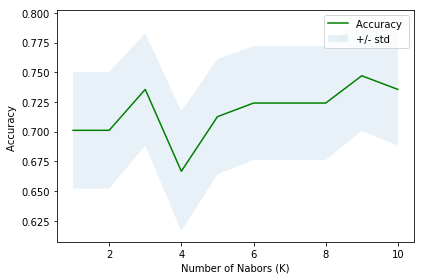

The best accuracy: 0.7471 on the testing set can be achieved at K =  9
The best ROC : 0.7570 on the testing set can be achieved at K =  9
The Jaccard similary is : 0.7816
The f1_score is : 0.7419
The log_loss is : 0.4432


In [77]:
plt.plot(range(1,K),mean_acc,'g')
plt.fill_between(range(1,K),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- std'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

print("The best accuracy: %.4f on the testing set can be achieved at K =  %.f" % (mean_acc.max(), mean_acc.argmax()+1))
print("The best ROC : %.4f on the testing set can be achieved at K =  %.f" % (roc.max(), roc.argmax()+1))



y_test_predict = KNeighborsClassifier(n_neighbors = 9).fit(X_train, y_train).predict(X_test)
y_test_prob = KNeighborsClassifier(n_neighbors = 9).fit(X_train, y_train).predict_proba(X_test)

print("The Jaccard similary is : %.4f" % jaccard_similarity_score(y_test, clf.predict(X_test), normalize=True))
print("The f1_score is : %.4f" % f1_score(y_test, y_test_predict, average='weighted'))
print("The log_loss is : %.4f" % log_loss(y_test,y_test_prob, normalize=True))

# Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [24]:
parameters = {'min_samples_split' : range(5,50,5),'max_depth': range(1,5,1), 'criterion': ['gini', 'entropy']}
clf_tree = DecisionTreeClassifier()
grid2 = GridSearchCV(clf_tree,parameters, cv =5)
grid2.fit(X_train,y_train)
y_train_prob2 = grid2.predict_proba(X_train)[:,1]
auc_score_train2 = metrics.roc_auc_score(y_train, y_train_prob2)

y_test_prob2  = grid2.predict_proba(X_test)[:,1]
auc_score_test2 = metrics.roc_auc_score(y_test, y_test_prob2)
y_test_predict2 = grid2.predict(X_test)

print("Best ROC on training set is: %.4f" % auc_score_train2)
print("Best ROC on testing set is: %.4f" % auc_score_test2)
print("Best Accuracy on testing set is: %.4f" % metrics.accuracy_score(y_test, y_test_predict2))
print("Best parameters: \n{}".format(grid2.best_params_))

Best ROC on training set is: 0.7559
Best ROC on testing set is: 0.7237
Best Accuracy on testing set is: 0.7816
Best parameters: 
{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5}


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [78]:
y_test_predict = DecisionTreeClassifier(criterion='gini',max_depth = 1 ,min_samples_split= 5).fit(X_train, y_train).predict(X_test)
y_test_prob = DecisionTreeClassifier(criterion='gini',max_depth = 1 ,min_samples_split= 5 ).fit(X_train, y_train).predict_proba(X_test)

print("The Jaccard similary is : %.4f" % jaccard_similarity_score(y_test, clf.predict(X_test), normalize=True))
print("The f1_score is : %.4f" % f1_score(y_test, y_test_predict, average='weighted'))
print("The log_loss is : %.4f" % log_loss(y_test,y_test_prob, normalize=True))

The Jaccard similary is : 0.7816
The f1_score is : 0.6858
The log_loss is : 0.4463


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Support Vector Machine

In [25]:
from sklearn.svm import SVC

In [26]:
svm = SVC(probability=True)
parameters3 = {'C' : [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['rbf','poly','sigmoid','linear']}
grid3 = GridSearchCV(svm, parameters3, cv =5)
grid3.fit(X_train,y_train)

y_test_predict3 = grid3.predict(X_test)
y_test_prob3  = grid3.predict_proba(X_test)[:,1]
auc_score_test3 = metrics.roc_auc_score(y_test, y_test_prob3)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [27]:
print("Best ROC on testing set is: %.4f" % auc_score_test3)
print("Best Accuracy on testing set is: %.4f" % metrics.accuracy_score(y_test, y_test_predict3))
print("Best parameters: \n{}".format(grid3.best_params_))

Best ROC on testing set is: 0.6072
Best Accuracy on testing set is: 0.7126
Best parameters: 
{'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}


In [80]:
y_test_predict = SVC(C = 0.1, gamma=1, kernel ='sigmoid',probability=True).fit(X_train, y_train).predict(X_test)
y_test_prob = SVC(C = 0.1, gamma=1, kernel ='sigmoid',probability=True).fit(X_train, y_train).predict_proba(X_test)

print("The Jaccard similary is : %.4f" % jaccard_similarity_score(y_test, clf.predict(X_test), normalize=True))
print("The f1_score is : %.4f" % f1_score(y_test, y_test_predict, average='weighted'))
print("The log_loss is : %.4f" % log_loss(y_test,y_test_prob, normalize=True))

The Jaccard similary is : 0.7816
The f1_score is : 0.6960
The log_loss is : 0.5180


# Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
LR = LogisticRegression(solver='liblinear')
parameters4 = {'C' : [0.001, 0.01, 0.1, 1, 10], 'max_iter': [50, 100, 200, 300]}
grid4 = GridSearchCV(LR, parameters4, cv =5)
grid4.fit(X_train,y_train)
y_test_predict4 = grid4.predict(X_test)
y_test_prob4  = grid4.predict_proba(X_test)[:,1]
auc_score_test4 = metrics.roc_auc_score(y_test, y_test_prob4)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [30]:
print("Best ROC on testing set is: %.4f" % auc_score_test4)
print("Best Accuracy on testing set is: %.4f" % metrics.accuracy_score(y_test, y_test_predict4))
print("Best parameters: \n{}".format(grid4.best_params_))

Best ROC on testing set is: 0.7713
Best Accuracy on testing set is: 0.7586
Best parameters: 
{'C': 0.001, 'max_iter': 50}


In [83]:
y_test_predict = LogisticRegression(C = 0.001, max_iter= 50, solver='liblinear').fit(X_train, y_train).predict(X_test)
y_test_prob =LogisticRegression(C = 0.001, max_iter= 50, solver='liblinear').fit(X_train, y_train).predict_proba(X_test)

print("The Jaccard similary is : %.4f" % jaccard_similarity_score(y_test, clf.predict(X_test), normalize=True))
print("The f1_score is : %.4f" % f1_score(y_test, y_test_predict, average='weighted'))
print("The log_loss is : %.4f" % log_loss(y_test,y_test_prob, normalize=True))

The Jaccard similary is : 0.7816
The f1_score is : 0.7185
The log_loss is : 0.6694


# Model Evaluation using Test set

In [53]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [32]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-10-19 04:07:01--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-10-19 04:07:01 (156 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [33]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

col = [0,1]
test_df.drop(test_df.columns[col], axis = 1, inplace = True) 
test_df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [34]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] =test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
Feature1 = test_df[['Principal','terms','age','Gender','weekend']]
Feature1 = pd.concat([Feature1,pd.get_dummies(test_df['education'])], axis=1)
Feature1.drop(['Master or Above'], axis = 1,inplace=True)
Feature1.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [35]:
X = Feature1
test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)
y = test_df['loan_status'].values
print(X[0:5])
print(y[0:5])

   Principal  terms  age  Gender  weekend  Bechalor  High School or Below  \
0       1000     30   50       1        0         1                     0   
1        300      7   35       0        1         0                     0   
2       1000     30   43       1        1         0                     1   
3       1000     30   26       0        1         0                     0   
4        800     15   29       0        1         1                     0   

   college  
0        0  
1        0  
2        0  
3        1  
4        0  
[1 1 1 1 1]


In [56]:
models = [{'Algorithm': 'KNN', 'model': clf } ,{'Algorithm': 'Decision Tree', 'model': grid2}, {'Algorithm': 'SVM', 'model': grid3 }, {'Algorithm': 'LogisticRegression', 'model': grid4 }]
jaccard = np.zeros(len(models))
F1_score = np.zeros(len(models))
Log_loss = np.zeros(len(models))

## not enough computation power so cannot run the following code, so break the process down to smaller parts
#for idx, model in enumerate(models):
#    model = model['model']
#    model.fit(X, y) #train the model
#    y_pred = model.predict(X)
#    y_prob = model.predict_proba(X)
#    jaccard[idx] = jaccard_similarity_score(y, y_pred, normalize=True)
#    Log_loss[idx] = log_loss(y, y_prob, normalize=True)
#    F1_score[idx] = f1_score(y, y_pred, average='weighted')


# score with KNN model     
y_pred1 = clf.predict(X)
y_prob1 = clf.predict_proba(X)
jaccard[0] = jaccard_similarity_score(y, y_pred1, normalize=True)
Log_loss[0] = log_loss(y,y_prob1, normalize=True)
F1_score[0] = f1_score(y, y_pred1, average='weighted')

In [57]:
# score with Decision Tree model     
y_pred2 = grid2.predict(X)
y_prob2 = grid2.predict_proba(X)
jaccard[1] = jaccard_similarity_score(y, y_pred2, normalize=True)
Log_loss[1] = log_loss(y,y_prob2, normalize=True)
F1_score[1] = f1_score(y, y_pred2, average='weighted')

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [58]:
# score with SVM model     
y_pred3 = grid3.predict(X)
y_prob3 = grid3.predict_proba(X)
jaccard[2] = jaccard_similarity_score(y, y_pred3, normalize=True)
Log_loss[2] = log_loss(y,y_prob3, normalize=True)
F1_score[2] = f1_score(y, y_pred3, average='weighted')

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [59]:
# score with LogisticRegression model     
y_pred4 = grid4.predict(X)
y_prob4 = grid4.predict_proba(X)
jaccard[3] = jaccard_similarity_score(y, y_pred4, normalize=True)
Log_loss[3] = log_loss(y,y_prob4, normalize=True)
F1_score[3] = f1_score(y, y_pred4, average='weighted')

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [69]:
Algorithm = ['KNN', 'Decision Tree', 'SVM', 'LogisticRegression']

In [72]:
evaludation_metrics = pd.DataFrame({'Algorithm': Algorithm , 'Jaccard': jaccard, 'F1-score':F1_score, 'Log_loss': Log_loss} )
evaludation_metrics

,Algorithm,Jaccard,F1-score,Log_loss
0,KNN,0.703704,0.695921,0.530102
1,Decision Tree,0.740741,0.630418,0.494820
2,SVM,0.740741,0.630418,0.573129
3,LogisticRegression,0.259259,0.106754,3.988453


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>